# Test diferent Vectorizers and n-grams sizes

In [1]:
import pandas as pd

dataset = pd.read_excel('OpArticles_ADUs.xlsx')

#### Preprocessing

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

corpus = []
stemmer = RSLPStemmer()
stopwords_list = stopwords.words('portuguese')
stopwords_list.remove('não')

for i in range(0, dataset['tokens'].size):
    review = re.sub('[^a-zA-Z\u00C0-\u00ff]', ' ', dataset['tokens'][i]).lower()
    review = ' '.join([stemmer.stem(w) for w in review.split() if not w in set(stopwords_list)])
    corpus.append(review)

## Document Representation

We need to transform the data in the reduced-vocabulary corpus into a dataset that can be handled by machine learning models. Each review in our corpus is still rather unstructured: it is simply a lists of tokens. We will transform each review into a representation that makes use of the same set of features for the whole dataset.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

y = dataset['label']

def test_vectorizer(vectorizer):
    # Fit vectorizer
    start = time.time()
    X = vectorizer.fit_transform(corpus).toarray()
    stop = time.time()
    print("Vectorizer fit time: %0.2fs" % (stop - start))
    print("(Number of samples, Number of features):", X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

    # Classification
    start = time.time()
    clf = ComplementNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    stop = time.time()

    print("\nModel time: %0.2fs" % (stop - start))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=clf.classes_), display_labels=clf.classes_).plot()

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Bag-of-Words model

The simplest way to do it is to create a *bag-of-words* model, which ignores word sequence.

We can use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which converts a collection of text documents to a matrix of token counts.

Vectorizer fit time: 0.38s
(Number of samples, Number of features): (16743, 8256)

Model time: 6.57s

Classification report:
               precision    recall  f1-score   support

        Fact       0.42      0.43      0.43       733
      Policy       0.30      0.41      0.34       133
       Value       0.61      0.53      0.57      1621
    Value(+)       0.30      0.34      0.32       282
    Value(-)       0.43      0.51      0.46       580

    accuracy                           0.48      3349
   macro avg       0.41      0.44      0.42      3349
weighted avg       0.50      0.48      0.49      3349



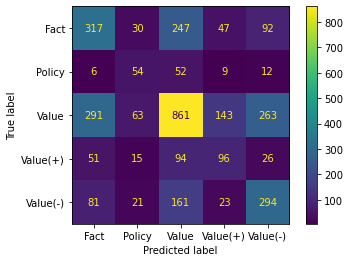

In [5]:
test_vectorizer(CountVectorizer())

### 1-hot vectors

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) includes a parameter (*binary*) that allows us to represent each review as a 1-hot vector with a 0 or a 1 for each of the features, indicating whether the corresponding token appears in the review.

Vectorizer fit time: 0.30s
(Number of samples, Number of features): (16743, 8256)

Model time: 8.15s

Classification report:
               precision    recall  f1-score   support

        Fact       0.42      0.43      0.43       733
      Policy       0.30      0.44      0.36       133
       Value       0.61      0.53      0.57      1621
    Value(+)       0.31      0.34      0.33       282
    Value(-)       0.44      0.52      0.47       580

    accuracy                           0.49      3349
   macro avg       0.42      0.45      0.43      3349
weighted avg       0.50      0.49      0.49      3349



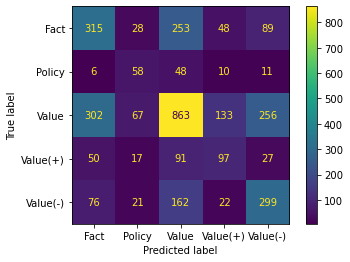

In [6]:
test_vectorizer(CountVectorizer(binary=True))

### TF-IDF

We can adjust the counts of each word in a document by considering how many times it occurs in the document (its *term frequency TF*) and in how many documents it occurs (its *document frequency DF*). [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) provides a way to directly obtain TF-IDF weighted features: the term frequency of a word is multiplied by its *inverse* document frequency.

Vectorizer fit time: 0.37s
(Number of samples, Number of features): (16743, 8256)

Model time: 0.37s

Classification report:
               precision    recall  f1-score   support

        Fact       0.44      0.41      0.42       733
      Policy       0.24      0.31      0.27       133
       Value       0.59      0.60      0.59      1621
    Value(+)       0.34      0.33      0.33       282
    Value(-)       0.46      0.46      0.46       580

    accuracy                           0.50      3349
   macro avg       0.41      0.42      0.42      3349
weighted avg       0.50      0.50      0.50      3349



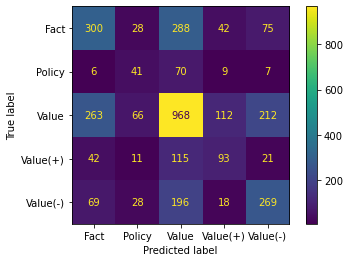

In [7]:
test_vectorizer(TfidfVectorizer())

TfidfVectorizer also contains _binary_ argument, where all non-zero term counts are set to 1. This does not mean outputs will have only 0/1 values, only that the tf term in tf-idf is binary. (Set idf and normalization to False to get 0/1 outputs).

So we will only stick to the 3 representations above and procede testing

Vectorizer fit time: 0.34s
(Number of samples, Number of features): (16743, 8256)

Model time: 0.37s

Classification report:
               precision    recall  f1-score   support

        Fact       0.45      0.42      0.43       733
      Policy       0.26      0.25      0.25       133
       Value       0.59      0.64      0.62      1621
    Value(+)       0.35      0.31      0.33       282
    Value(-)       0.49      0.44      0.46       580

    accuracy                           0.52      3349
   macro avg       0.43      0.41      0.42      3349
weighted avg       0.51      0.52      0.51      3349



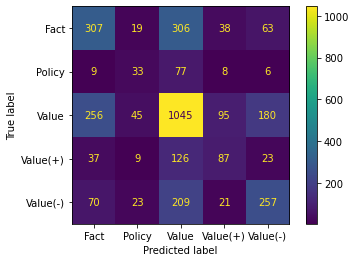

In [8]:
test_vectorizer(TfidfVectorizer(binary=True, use_idf=False))

### Bi-grams

Vectorizer fit time: 0.51s
(Number of samples, Number of features): (16743, 61558)

Model time: 57.79s

Classification report:
               precision    recall  f1-score   support

        Fact       0.39      0.35      0.37       733
      Policy       0.10      0.71      0.18       133
       Value       0.65      0.36      0.46      1621
    Value(+)       0.31      0.37      0.34       282
    Value(-)       0.48      0.45      0.46       580

    accuracy                           0.39      3349
   macro avg       0.39      0.45      0.36      3349
weighted avg       0.51      0.39      0.42      3349



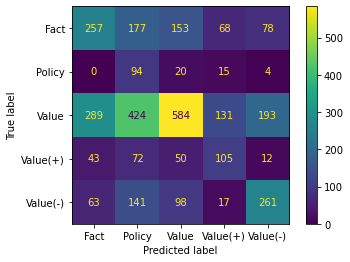

In [9]:
test_vectorizer(CountVectorizer(ngram_range=(2,2)))

Vectorizer fit time: 0.67s
(Number of samples, Number of features): (16743, 61558)

Model time: 56.99s

Classification report:
               precision    recall  f1-score   support

        Fact       0.39      0.35      0.37       733
      Policy       0.10      0.71      0.18       133
       Value       0.64      0.36      0.46      1621
    Value(+)       0.31      0.37      0.34       282
    Value(-)       0.48      0.45      0.46       580

    accuracy                           0.39      3349
   macro avg       0.39      0.45      0.36      3349
weighted avg       0.51      0.39      0.42      3349



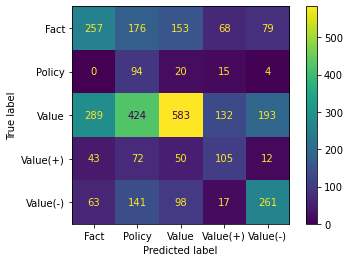

In [10]:
test_vectorizer(CountVectorizer(binary=True, ngram_range=(2,2)))

Vectorizer fit time: 0.71s
(Number of samples, Number of features): (16743, 61558)

Model time: 3.57s

Classification report:
               precision    recall  f1-score   support

        Fact       0.40      0.36      0.38       733
      Policy       0.10      0.70      0.18       133
       Value       0.64      0.37      0.47      1621
    Value(+)       0.33      0.37      0.35       282
    Value(-)       0.49      0.45      0.47       580

    accuracy                           0.39      3349
   macro avg       0.39      0.45      0.37      3349
weighted avg       0.51      0.39      0.43      3349



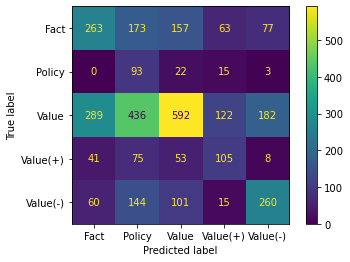

In [11]:
test_vectorizer(TfidfVectorizer(ngram_range=(2,2)))

### UniBi-grams

Vectorizer fit time: 0.83s
(Number of samples, Number of features): (16743, 69814)

Model time: 66.67s

Classification report:
               precision    recall  f1-score   support

        Fact       0.41      0.39      0.40       733
      Policy       0.22      0.63      0.33       133
       Value       0.64      0.45      0.53      1621
    Value(+)       0.28      0.45      0.35       282
    Value(-)       0.46      0.53      0.49       580

    accuracy                           0.46      3349
   macro avg       0.40      0.49      0.42      3349
weighted avg       0.51      0.46      0.47      3349



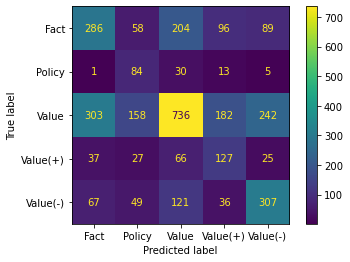

In [12]:
test_vectorizer(CountVectorizer(ngram_range=(1,2)))

Vectorizer fit time: 0.83s
(Number of samples, Number of features): (16743, 69814)

Model time: 67.39s

Classification report:
               precision    recall  f1-score   support

        Fact       0.41      0.39      0.40       733
      Policy       0.23      0.64      0.33       133
       Value       0.64      0.45      0.53      1621
    Value(+)       0.28      0.46      0.35       282
    Value(-)       0.46      0.53      0.49       580

    accuracy                           0.46      3349
   macro avg       0.40      0.49      0.42      3349
weighted avg       0.51      0.46      0.47      3349



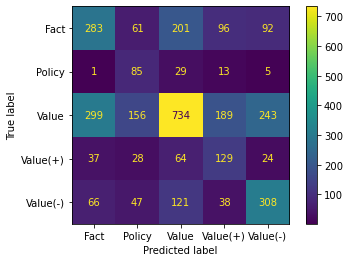

In [13]:
test_vectorizer(CountVectorizer(binary=True, ngram_range=(1,2)))

Vectorizer fit time: 0.67s
(Number of samples, Number of features): (16743, 69814)

Model time: 5.01s

Classification report:
               precision    recall  f1-score   support

        Fact       0.44      0.40      0.42       733
      Policy       0.34      0.47      0.40       133
       Value       0.61      0.62      0.61      1621
    Value(+)       0.38      0.39      0.38       282
    Value(-)       0.50      0.49      0.50       580

    accuracy                           0.52      3349
   macro avg       0.45      0.47      0.46      3349
weighted avg       0.52      0.52      0.52      3349



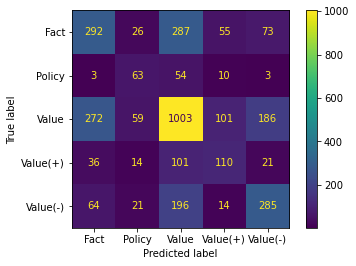

In [14]:
test_vectorizer(TfidfVectorizer(ngram_range=(1,2)))

### Conclusions

As we can see the _TfidfVectorizer_ achieve better results (not by much), and we think it is better to also take into account for the document frequency and not only the term count, so this is the Vectorizer that we will use for the classification tasks

### Explore parameters

In this section we will explore some of the parameters in order to achieve the best results possible while minimizing classification time

#### Strip accents

Remove accents and perform other character normalization

Vectorizer fit time: 1.30s
(Number of samples, Number of features): (16743, 69263)

Model time: 5.05s

Classification report:
               precision    recall  f1-score   support

        Fact       0.43      0.39      0.41       733
      Policy       0.34      0.47      0.39       133
       Value       0.61      0.62      0.61      1621
    Value(+)       0.39      0.39      0.39       282
    Value(-)       0.50      0.49      0.50       580

    accuracy                           0.52      3349
   macro avg       0.45      0.47      0.46      3349
weighted avg       0.52      0.52      0.52      3349



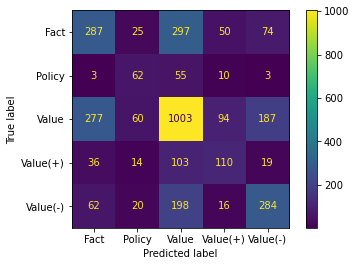

In [15]:
test_vectorizer(TfidfVectorizer(ngram_range=(1,2), strip_accents='unicode'))

Even though metrics are basically unchanged (in case of unigrams it lowers f1-score a lot), we are not sure how the words are affected turning into the same base form after the accents are stripped. Therefore we will not use this parameter.

#### Document Frequency

Ignore terms that appear less than 3 times, and terms that appear in more than 80% of the documents

Vectorizer fit time: 1.64s
(Number of samples, Number of features): (16743, 19262)

Model time: 1.03s

Classification report:
               precision    recall  f1-score   support

        Fact       0.43      0.41      0.42       733
      Policy       0.38      0.44      0.41       133
       Value       0.60      0.60      0.60      1621
    Value(+)       0.42      0.41      0.42       282
    Value(-)       0.48      0.48      0.48       580

    accuracy                           0.52      3349
   macro avg       0.46      0.47      0.47      3349
weighted avg       0.52      0.52      0.52      3349



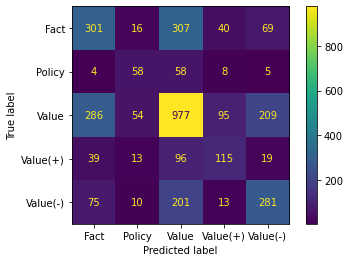

In [16]:
test_vectorizer(TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.8))

Same accuracy, higher f1-scores for the lower support classes, and significantly lower number of features. An important parameter to use in the classification task.

### UniBiTri-grams

Vectorizer fit time: 0.82s
(Number of samples, Number of features): (16743, 30172)

Model time: 1.59s

Classification report:
               precision    recall  f1-score   support

        Fact       0.43      0.38      0.40       733
      Policy       0.29      0.37      0.32       133
       Value       0.58      0.63      0.60      1621
    Value(+)       0.46      0.37      0.41       282
    Value(-)       0.49      0.44      0.46       580

    accuracy                           0.51      3349
   macro avg       0.45      0.44      0.44      3349
weighted avg       0.51      0.51      0.51      3349



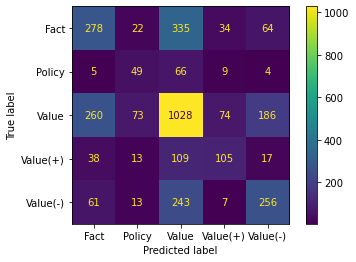

In [17]:
test_vectorizer(TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.8))